<h1> Wavelets test on simulated data </h1> 

In [97]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
os.chdir('/home/dana_z/ssd_2TB/6OHDA')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as Mcolors
import matplotlib.cm as cmx
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP
import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings
import pandas as pd
import sqlalchemy as db
import gc
from tqdm import tqdm
import seaborn as sns
import pywt # wavelet package

<IPython.core.display.Javascript object>


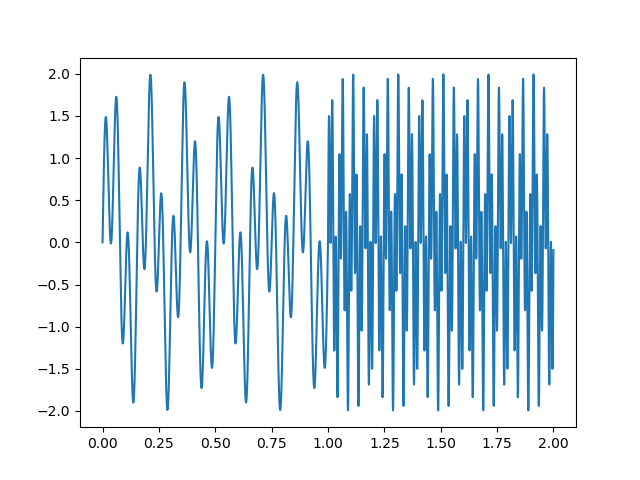

In [78]:
dt = 1/3051.7578125
t = np.arange(0,2/dt)*dt
f = 20
ch = int(np.floor(len(t)/2))
x = np.sin(t*2*np.pi*f)+np.sin(t*2*np.pi*f)
x[ch:] = np.sin(t[ch:]*2*np.pi*f)+np.sin(t[ch:]*2*np.pi*65)
x[:ch] = np.sin(t[:ch]*2*np.pi*f)+np.sin(t[:ch]*2*np.pi*6)
plt.plot(t,x)

In [84]:
minS = 45
maxS = 950
waveletName = 'cmor14.0-1.5'
f = np.empty((maxS-minS,1))
for j in range(minS,maxS):
    f[j-minS]=pywt.scale2frequency(waveletName , j)*(1/dt)
[intF,inds] = np.unique(np.floor(f),return_index=True)
print(f[inds].T)

[[  4.99742      5.99952388   6.99944452   7.9888948    8.99339237
    9.99484     10.97754609  11.9833422   12.9678094   13.99888905
   14.95959712  15.94995372  16.95421007  17.95151654  18.99434323
   19.98967999  20.99833357  21.90256803  22.88818359  23.96668439
   24.87846043  25.86235434  26.92727482  27.91241902  28.9723843
   29.91919424  30.92997783  31.78914388  32.93263826  33.90842014
   34.94379175  35.76278687  36.91642515  37.83170842  38.79353151
   39.80553668  40.87175642  41.99666714  42.78165158  43.59654018
   44.87879136  45.77636719  46.71057876  47.68371582  48.69826297
   49.75692086  50.86263021  51.43412044  52.61651401  53.85454963
   54.49567522  55.82483803  56.51403356  57.94476859  58.68765024
   59.44982752  60.23206209  61.85995566  62.70735231  63.57828776
   64.4737566   65.39481027  66.34256114  67.31818704  68.3229361
   69.3581321   70.42518029  71.52557373  72.6609003   73.8328503
   75.0432249   76.29394531  77.58706303  78.92477101  80.3094161

(87, 6104) (87,)


<IPython.core.display.Javascript object>


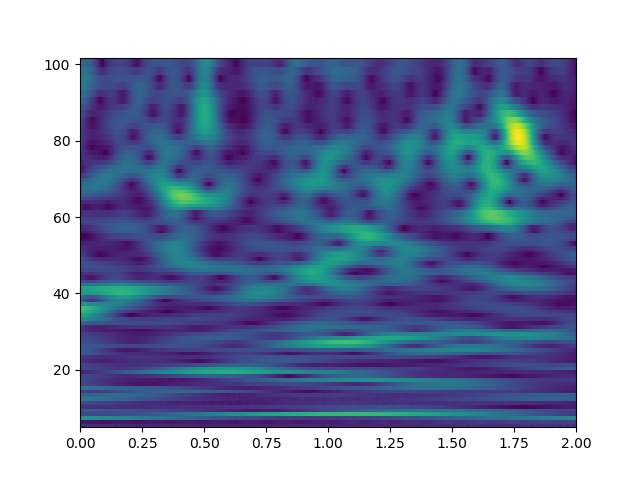

In [85]:
 #must be from waveletsOptions
scales = inds+minS
[coefficients, frequencies] = pywt.cwt(x, scales, waveletName, dt)
print(coefficients.shape,frequencies.shape)
fig, ax  = plt.subplots(1,1)
ax.pcolormesh(t,frequencies,np.abs(coefficients))

(87, 6104) (87,)


<IPython.core.display.Javascript object>


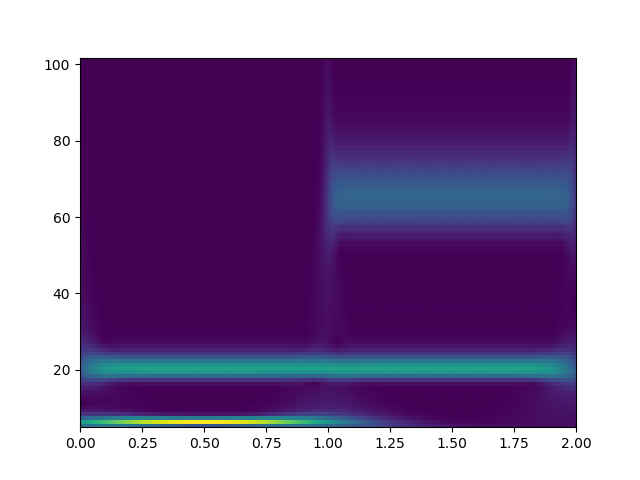

In [81]:
waveletName = 'cmor2.0-1.5' #must be from waveletsOptions
scales = inds+minS
[coefficients, frequencies] = pywt.cwt(x, scales, waveletName, dt)
print(coefficients.shape,frequencies.shape)
fig, ax  = plt.subplots(1,1)
ax.pcolormesh(t,frequencies,np.abs(coefficients))

In [89]:
f = h5py.File('Spectograms.hdf5','r')
 
data =  getData('FinalData_6OHDA.h5',['lfp','speed'],period ='Pre', mice='0761',day = lambda x: x==0)
print(data.keys())


cleaning up lfp data
cleaning up speed data
dict_keys(['0761_BaselineA', '0761_BaselineL', '0761_BaselineS'])


In [100]:
sess = '0761_BaselineL'
m = '0761'
dtS = 1/data[sess]['speed']['Fs']
dtL = 1/data[sess]['lfp']['FS']
ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

tPlot = np.linspace(-2,2,4/dtL)

mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
mvmtOnsetL = np.full_like(tl,False)
for si in ts[mvmtOnset]:
    ti = np.argmin(np.abs(tl-si))
    mvmtOnsetL[ti] = True
del mvmtOnset

freq = f[m]['freq'].value
coeff = np.abs(f[m][sess]['Pre']['coeff'].value)

totP = np.sum(coeff,axis=1)
coeff = coeff.T/totP.T
coeff = coeff.T

lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
coeff[:,(lfpOutliers[:,0]==1)] = np.nan
coeff = coeff.T

al = alignToOnset(coeff,(mvmtOnsetL==1), winPost =2/dtL, winPre = 2/dtL)

print(al.shape)
   

/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.
  


found  0.0  outlier points
(12206, 87, 15)


<IPython.core.display.Javascript object>


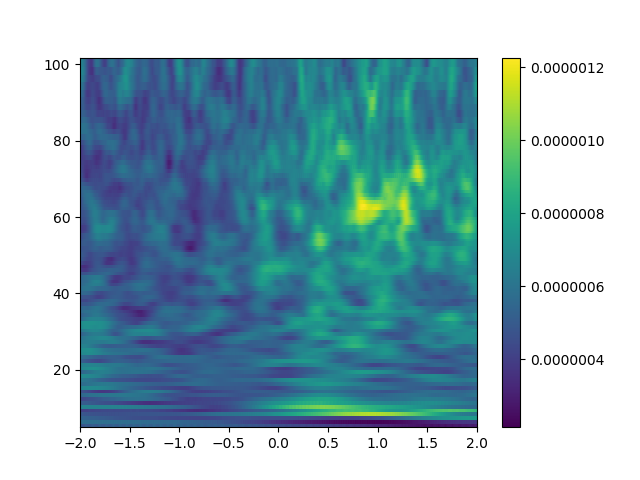

In [103]:
im = plt.pcolormesh(tPlot[:-1],freq,np.nanmean(al,axis=2).T)
plt.colorbar(im)